<a class="anchor" id="0"></a>

# **SARIMA Model for Time Series Forecasting: COVID-19 in Canada**

**Author:** Stephen Prudente  
**Start Date:** 20th January, 2021

**Purpose:** The objective of this notebook is to explore using SARIMA Time Series Forecasting on a COVID-19 dataset from the Canadian Government open datasets repository to predict COVID-19 positive cases. SARIMA (Seasonal Autoregressive Integrated Moving Average).

**Dataset:** The dataset being used comes from the Canadian Government open data portal. The variable being focused on is the number of COVID-19 tests done as it's shown to have a positive correlation towards COVID-19 positive cases as well as being statistically significant. Therefore, the variable 'numteststoday' is the main focus of this analysis.

## Importing Libraries  <a name="log"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

from math import sqrt

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from matplotlib.pylab import rcParams
%matplotlib inline

# Read & Prepare Data  <a name="log"></a>

In [2]:
# Import the data
df = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv")

df = df[df['prname'].str.contains('Canada')]

#Index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df = df[['numconf','numtotal','numrecover','avgtotal_last7','numtotal_last7','numtotal_last14','numtests','numdeaths','ratetests','numactive','numtoday','numteststoday','numrecoveredtoday']]

# Selecting the proper time period
df = df['2020-01-31':'2022-04-07'].resample('W').sum()

df.head()

,numconf,numtotal,numrecover,avgtotal_last7,numtotal_last7,numtotal_last14,numtests,numdeaths,ratetests,numactive,numtoday,numteststoday,numrecoveredtoday
date,,,,,,,,,,,,,
2020-02-02,4,4,0,0.00,0,0,0,0,0.00,4,0,0,0
2020-02-09,7,7,0,0.43,3,3,63,0,1.65,7,3,63,0
2020-02-16,8,8,0,0.57,4,4,109,0,2.85,8,1,46,0
2020-02-23,9,9,0,0.71,5,5,166,0,4.34,9,1,57,0
2020-03-01,85,85,0,7.72,54,61,2248,0,58.76,85,15,469,0


# Data Visualizations  <a name="log"></a>

- Heat map with the seasonal component

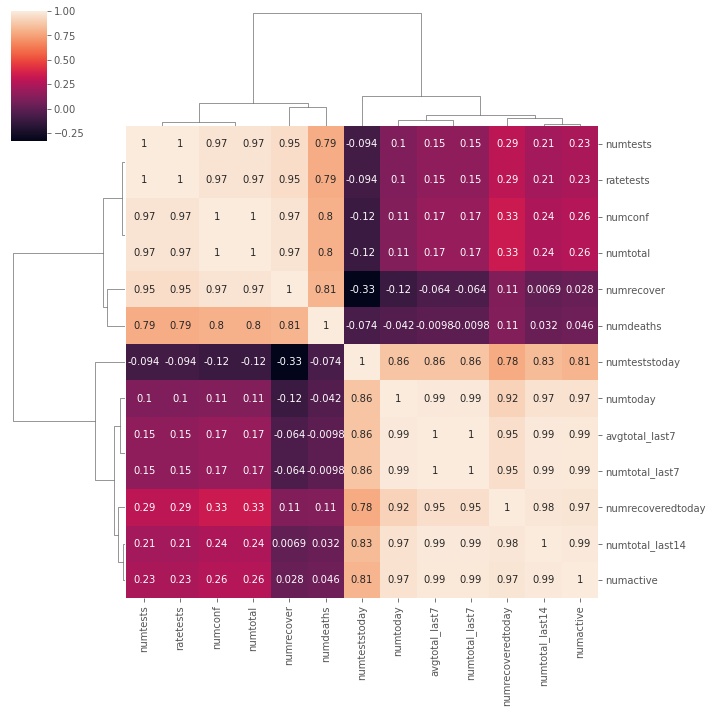

In [3]:
seasonality_dict = {
    ts: sm.tsa.seasonal_decompose(df[ts].dropna()).seasonal for ts in df.columns
}

# Compute corr matrix
seasonality_corr = pd.DataFrame(seasonality_dict).corr()

sns.clustermap(seasonality_corr, annot=True, square=True)
plt.show();

- Heat map without the seasonal component

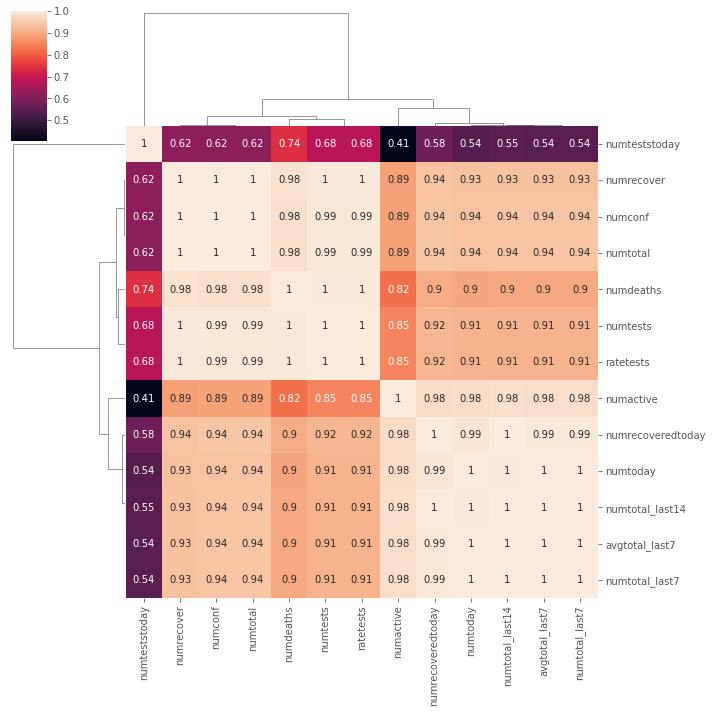

In [4]:
trend_dict = {
    ts: sm.tsa.seasonal_decompose(df[ts].dropna()).trend for ts in df.columns
}

# Compute corr matrix
trend_dict = pd.DataFrame(trend_dict).corr()

sns.clustermap(trend_dict, annot=True, square=True)
plt.show();

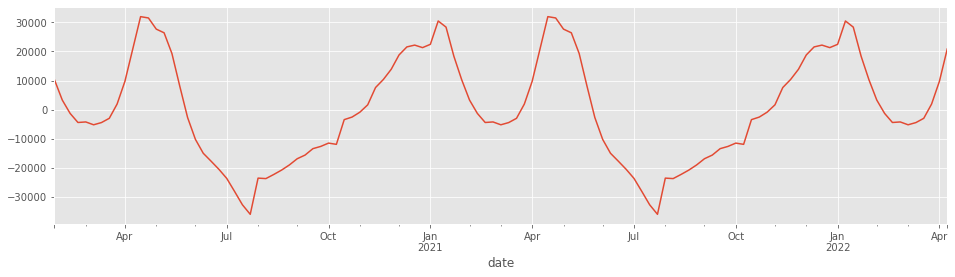

In [5]:
decomposition = sm.tsa.seasonal_decompose(df["avgtotal_last7"])

rcParams["figure.figsize"] = 16, 4
decomposition.seasonal.plot();

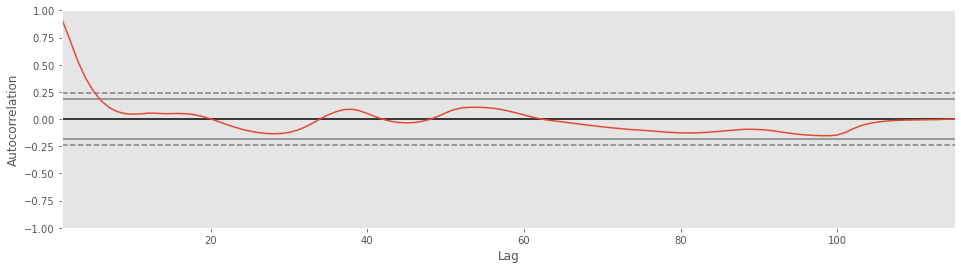

In [6]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['avgtotal_last7'])
plt.show()

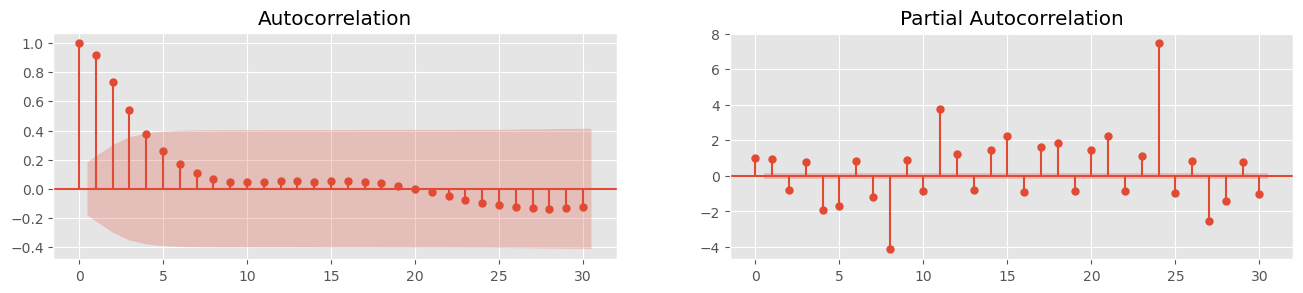

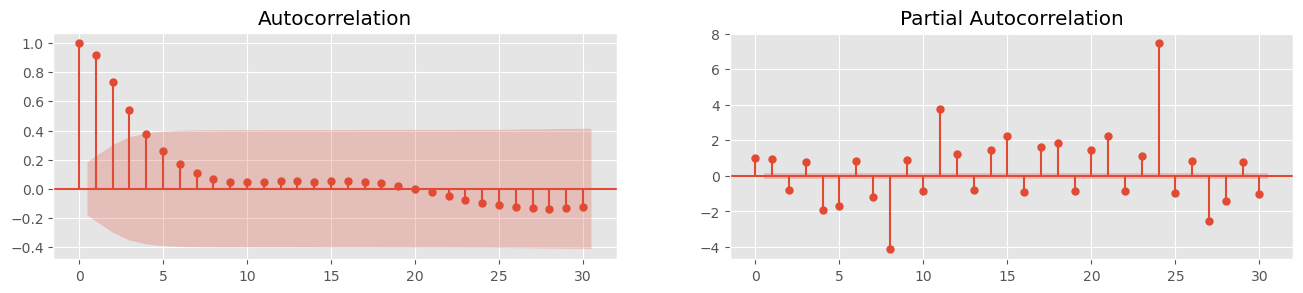

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['avgtotal_last7'].tolist(), lags=30, ax=axes[0])
plot_pacf(df['avgtotal_last7'].tolist(), lags=30, ax=axes[1])

# Feature Engineering  <a name="log"></a>

In [8]:
test_result=adfuller(df['avgtotal_last7'])

Autolag set to t-stat where it starts maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.

In [9]:
from statsmodels.tsa.stattools import adfuller

def ad_test(df):
     dftest = adfuller(df, autolag = 't-stat')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression and Critical Value Calculation :",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

- First Difference and Seasonal Difference

In [10]:
df['numteststoday First Difference'] = df['avgtotal_last7'] - df['avgtotal_last7'].shift(1)
df['Seasonal First Difference']=df['avgtotal_last7']-df['avgtotal_last7'].shift(12)
df.head()

,numconf,numtotal,numrecover,avgtotal_last7,numtotal_last7,numtotal_last14,numtests,numdeaths,ratetests,numactive,numtoday,numteststoday,numrecoveredtoday,numteststoday First Difference,Seasonal First Difference
date,,,,,,,,,,,,,,,
2020-02-02,4,4,0,0.00,0,0,0,0,0.00,4,0,0,0,NaN,NaN
2020-02-09,7,7,0,0.43,3,3,63,0,1.65,7,3,63,0,0.43,NaN
2020-02-16,8,8,0,0.57,4,4,109,0,2.85,8,1,46,0,0.14,NaN
2020-02-23,9,9,0,0.71,5,5,166,0,4.34,9,1,57,0,0.14,NaN
2020-03-01,85,85,0,7.72,54,61,2248,0,58.76,85,15,469,0,7.01,NaN


<AxesSubplot:xlabel='date'>

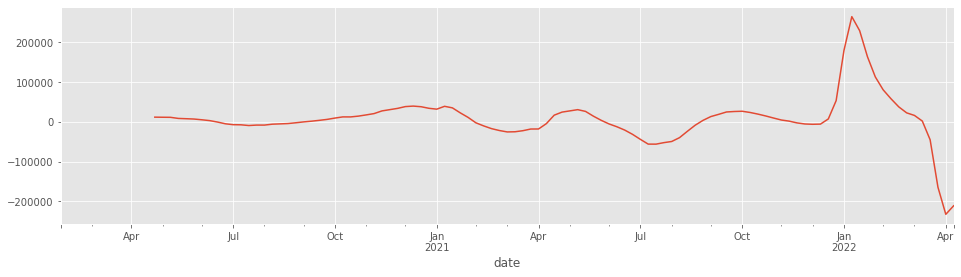

In [11]:
df['Seasonal First Difference'].plot()

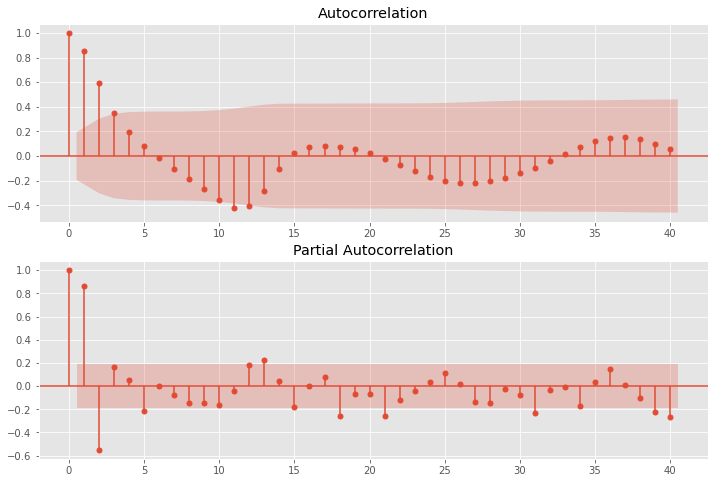

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

- Determining if the p-value is greater than the significance level (0.05).

In [13]:
ad_test(df['avgtotal_last7'])

1. ADF :  -2.7679360457672986
2. P-Value :  0.0630018504086179
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Value Calculation : 110
5. Critical Values :
	 1% :  -3.4912451337340342
	 5% :  -2.8881954545454547
	 10% :  -2.5809876033057852


In [14]:
best_model = SARIMAX(df['avgtotal_last7'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     avgtotal_last7   No. Observations:                  115
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -1099.027
Date:                            Sat, 09 Apr 2022   AIC                           2216.055
Time:                                    14:36:58   BIC                           2239.679
Sample:                                02-02-2020   HQIC                          2225.621
                                     - 04-10-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8697      0.753      1.155      0.248      -0.607       2.346
ar.L2         -0.4144      0.454   

# Training The Data  <a name="log"></a>

- Split the dataset into training and testing. Validate the set to calculate the R-Squared score and the mean asbolte percentage error. The data is being split into 2 parts that are approximately 72:25 ratio to represent a reasonable proportion based on the time frequency of the series.

In [15]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['avgtotal_last7'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['avgtotal_last7'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['avgtotal_last7'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['avgtotal_last7'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['avgtotal_last7'])
                                                               /np.abs(test['avgtotal_last7']))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.9122,15687.949355,5.441061e+08,23326.081756,19.025453


In [16]:
start=len(train)
end=len(train)+len(test)-1
pred=best_model.predict(start=start,end=end,typ='levels')
print(pred)

date
2021-12-12     17065.526006
2021-12-19     32224.623813
2021-12-26     47969.522188
2022-01-02    135708.044264
2022-01-09    324639.060851
2022-01-16    267804.973270
2022-01-23    181025.750450
2022-01-30    142981.103310
2022-02-06    105723.294221
2022-02-13     93046.069033
2022-02-20     62206.174903
2022-02-27     51503.834213
2022-03-06     39189.095511
2022-03-13     46578.351287
2022-03-20     39734.011387
2022-03-27     44838.732622
2022-04-03     42632.380031
2022-04-10     65278.914658
Freq: W-SUN, Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='date'>

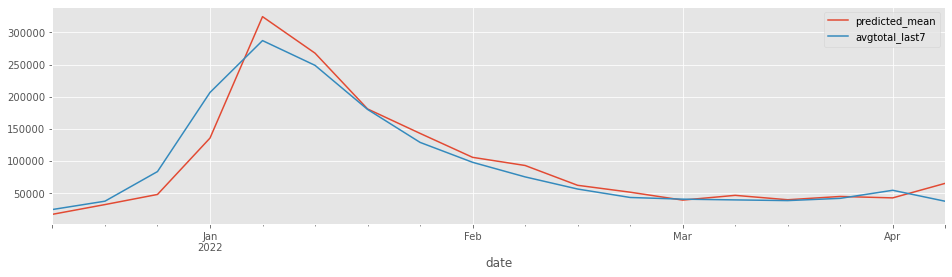

In [17]:
pred.plot(legend=True)
test['avgtotal_last7'].plot(legend=True)

In [18]:
test['avgtotal_last7'].mean()

95725.30055555556

In [19]:
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['avgtotal_last7']))
print(rmse)

23326.081756312884


In [20]:
best_model = SARIMAX(df['avgtotal_last7'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    avgtotal_last7   No. Observations:                  115
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood               -1216.349
Date:                           Sat, 09 Apr 2022   AIC                           2442.698
Time:                                   14:36:59   BIC                           2456.200
Sample:                               02-02-2020   HQIC                          2448.174
                                    - 04-10-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.4016      0.139     10.074      0.000       1.129       1.674
ma.L2          0.6252      0.225      2.774

<AxesSubplot:xlabel='date'>

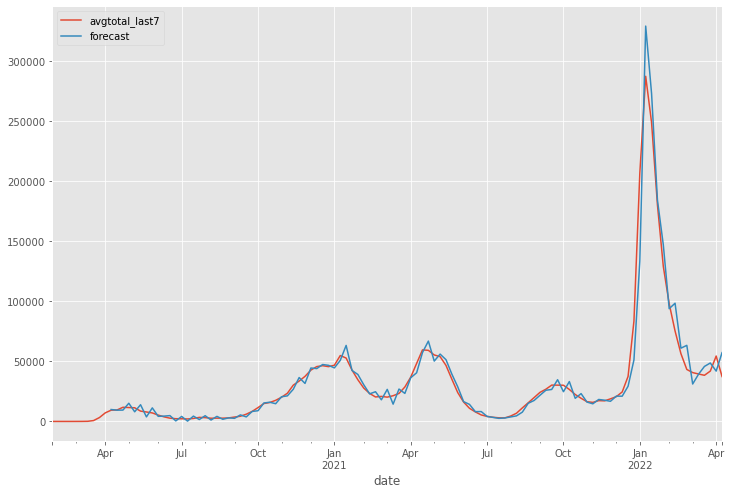

In [21]:
df['forecast']=best_model.predict(start=10,end=150,dynamic=False)
df[['avgtotal_last7','forecast']].plot(figsize=(12,8))

# Future Predictions  <a name="log"></a>

- Forecasting 30 steos ahead. Confidence intervals of the forecasted values. Plot the data. Plot the forecasted values. Plot the confidence intervals.

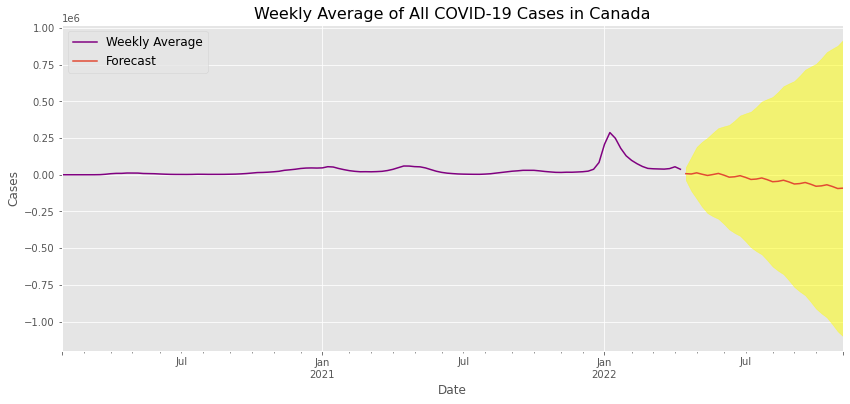

In [27]:
forecast_values = best_model.get_forecast(steps = 30)
forecast_ci = forecast_values.conf_int()
ax = df.plot(y='avgtotal_last7', label='Weekly Average',use_index=True , figsize = (14, 6), legend = True, color='purple')
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Weekly Average of All COVID-19 Cases in Canada', size = 16)
plt.ylabel('Cases', size=12)
plt.xlabel('Date', size=12)
plt.legend(loc='upper left', prop={'size': 12})
ax.axes.get_xaxis().set_visible(True)

plt.show()

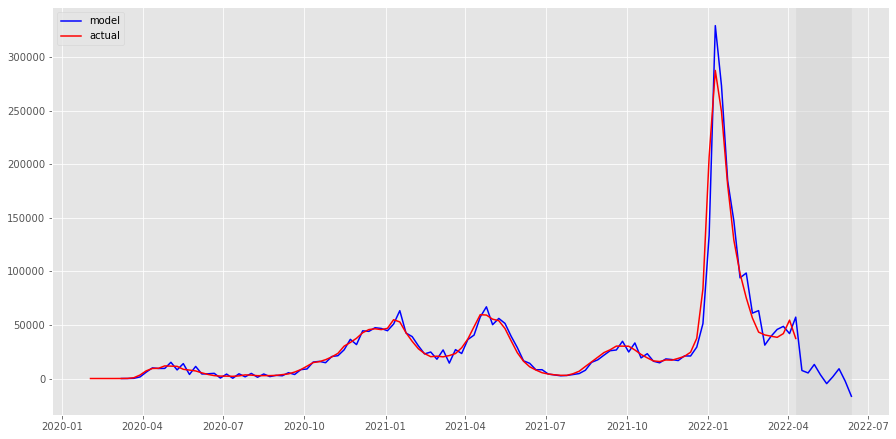

In [29]:
df['arima_model'] = best_model.fittedvalues
df['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=df.shape[0], end=df.shape[0] + 8)
forecast = df['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='b', label='model')
plt.axvspan(df.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df['avgtotal_last7'], color='r',label='actual')
plt.legend()
plt.show()